### Configuration

In [1]:
import os
import ipympl
import numpy as np
import pandas as pd
from scipy import stats

import mne
import yasa
from yasa import sw_detect
from yasa import spindles_detect
from scipy.stats import median_abs_deviation
import plotnine as pn

from utils__helpers_macro import robust_zscore
import utils__config

In [2]:
os.chdir(utils__config.working_directory)
os.getcwd()

'Z:\\Layton\\Sleep_083023'

### Parameters

In [3]:
fif_path = 'Cache/Subject05/Jul12/S05_Jul12_256hz.fif'
potato_path = 'Cache/Subject05/Jul12/S05_Jul12_potatogram.csv'
dictionary_path = 'Data/Subject05/S05_dictionary.xlsx'
legui_path = 'Cache/Subject05/Jul12/S05_electrodes.csv'
bad_channel_path = 'Cache/Subject05/Jul12/S05_bad_channels.csv'
sw_path = 'Cache/Subject05/Jul12/S05_SW_raw.csv'
kc_path = 'Cache/Subject05/Jul12/S05_KC_raw.csv'
sp_path = 'Cache/Subject05/Jul12/S05_SP_raw.csv'
event_path = 'Cache/Subject05/Jul12/S05_events_summary.csv'

In [4]:
sampling_freq = 256

### Load Data

In [5]:
raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = False)
print('Original channel count:', len(raw.ch_names))

# Select only macroelectrodes
raw.pick_types(seeg = True, ecog = True)

# Remove rejected channels
bad_channels = pd.read_csv(bad_channel_path)
bad_channels = bad_channels[bad_channels['channel'].isin(raw.ch_names)]
raw.drop_channels(ch_names = bad_channels['channel'].astype('string'))

print('Channel count after Channel Rejection:', len(raw.ch_names))

# Convert V to uV for YASA
data = raw.get_data() * 1e6

# Load hypnogram
hypnogram = np.loadtxt(potato_path, delimiter = ',')

C:\Users\lal85\AppData\Local\Temp\2\ipykernel_18380\1006497425.py:1: RuntimeWarning: This filename (Cache/Subject05/Jul12/S05_Jul12_256hz.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Original channel count: 74
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Channel count after Channel Rejection: 51


### Normalize with Robust Z-Score

Plot statistics of amplitudes and robust z-scores by channel

In [6]:
pn_data = pd.DataFrame(data.transpose())
pn_data.columns = raw.ch_names
pn_data = pn_data.reset_index()

pn_data = pn_data.melt(id_vars = ['index'], var_name = 'channel', value_name = 'amplitude')
pn_data.columns = ['sample', 'channel', 'amplitude']

#pn_data['rzscore'] = pn_data.groupby(['channel'])['amplitude'].transform(robust_zscore)

pn_data = pn_data.groupby(['channel']).agg({'amplitude' : [np.mean,
                                                           np.median,
                                                           lambda x: np.mean(np.abs(x)), 
                                                           lambda x: np.median(np.abs(x)),
                                                           np.std, 
                                                           median_abs_deviation, 
                                                           lambda x: x.quantile(0.10),
                                                           lambda x: x.quantile(0.25),
                                                           lambda x: x.quantile(0.75),
                                                           lambda x: x.quantile(0.90)]})
pn_data = pn_data.reset_index()

pn_data = pn_data.melt(id_vars = ['channel'], var_name = ['dummy', 'stat'], value_name = 'value')
pn_data.drop(columns = ['dummy'], inplace = True)
pn_data = pn_data.replace({'stat' : {'<lambda_0>' : 'abs_mean',
                                     '<lambda_1>' : 'abs_median',
                                     'std' : 'sd',
                                     'median_abs_deviation' : 'mad',
                                     '<lambda_2>' : 'q10', 
                                     '<lambda_3>' : 'q25', 
                                     '<lambda_4>' : 'q75', 
                                     '<lambda_5>' : 'q90'}})

amp_data = pn_data.copy(deep = True)
amp_data['stat'] = amp_data['stat'].astype('category')
amp_data['stat'] = amp_data['stat'].cat.reorder_categories(['q90', 'q75', 'q25', 'q10', 'mad', 'abs_median', 'median', 'sd', 'abs_mean', 'mean'])
amp_data.groupby(['stat']).describe().reset_index()

C:\Users\lal85\AppData\Local\Temp\2\ipykernel_18380\4076147282.py:10: FutureWarning: The provided callable <function mean at 0x0000020AE2096840> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
C:\Users\lal85\AppData\Local\Temp\2\ipykernel_18380\4076147282.py:10: FutureWarning: The provided callable <function median at 0x0000020AE21D7880> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'median' instead.
C:\Users\lal85\AppData\Local\Temp\2\ipykernel_18380\4076147282.py:10: FutureWarning: The provided callable <function std at 0x0000020AE2096A20> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'std' instead.
C:\Users\lal85\AppData\Local\Temp\2\ipykernel_18380\4076147282.py:36: FutureWar

stat value                                                          \
              count       mean        std         min        25%        50%   
0         q90  51.0  57.183927  20.095794   24.086459  40.869077  55.399364   
1         q75  51.0  26.872112   8.627427   11.514886  19.858059  26.655673   
2         q25  51.0 -27.224916   9.176741  -46.335454 -33.847786 -26.684466   
3         q10  51.0 -57.116008  20.112445 -103.531815 -67.678687 -54.566533   
4         mad  51.0  27.045330   8.873152   11.531831  19.977832  27.029721   
5  abs_median  51.0  27.061395   8.884082   11.532039  19.980716  27.037856   
6      median  51.0  -0.209514   0.901690   -3.094340  -0.649989  -0.087253   
7          sd  51.0  55.090440  18.707220   28.503038  41.725484  53.273334   
8    abs_mean  51.0  37.598618  12.796952   19.535110  26.689071  35.109794   
9        mean  51.0   0.037326   0.318117   -0.590166  -0.144175   0.032057   

                          
         75%         max  
0  68.390329  104.072528  
1  32.178582   45.700822  
2 -19.749329  -11.549827  
3 -40.811365  -24.170517  
4  32.880251   45.001634  
5  32.933753   45.009570  
6   0.362495    1.739537  
7  67.985322   98.936478  
8  44.679230   67.808805  
9   0.163550    1.063518

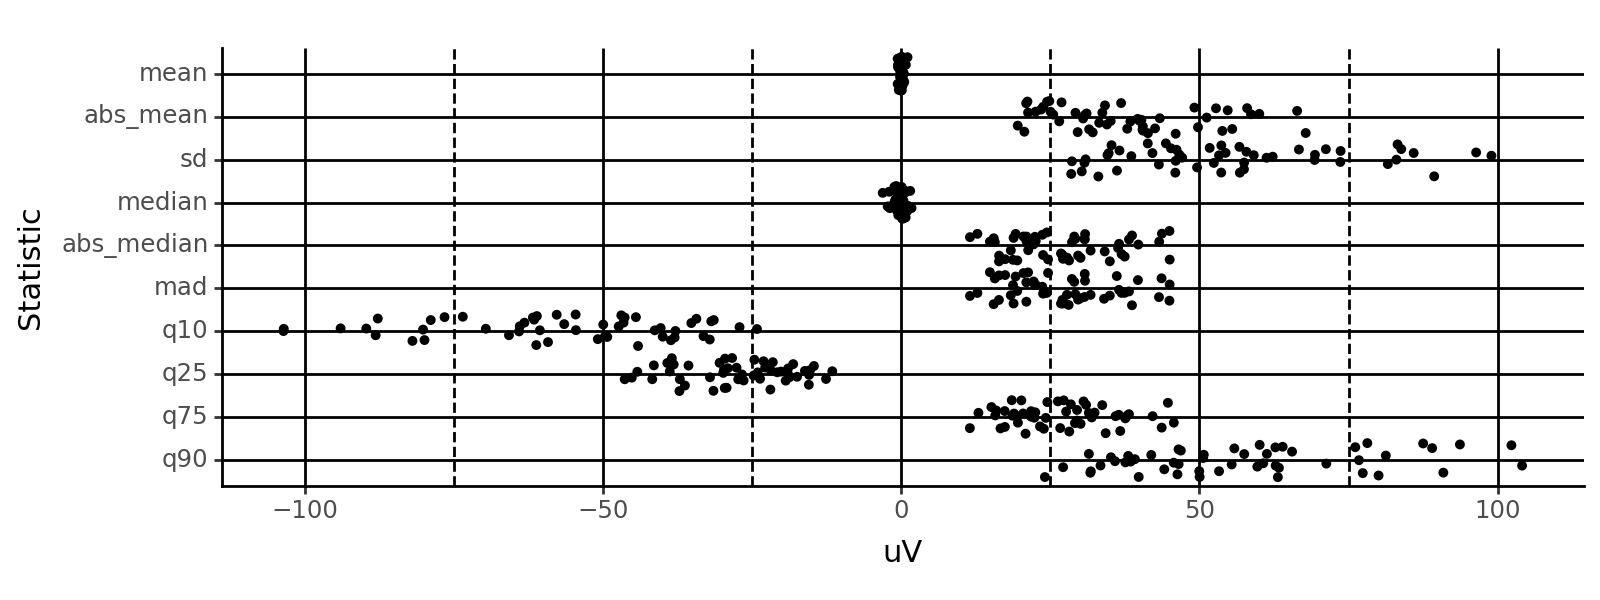

<Figure Size: (800 x 300)>

In [7]:
(pn.ggplot(amp_data)
 + pn.aes(x = 'stat', y = 'value')
 + pn.geom_jitter(size = 1)
 + pn.labs(x = 'Statistic', y = 'uV')
 + pn.theme_classic()
 + pn.theme(figure_size = (8, 3),
            panel_grid_major = pn.element_line(linetype = 'solid'),
            panel_grid_minor = pn.element_line(linetype = 'dashed'))
 + pn.coord_flip()
)

In [8]:
ex_uV = 100

ex_data = amp_data.groupby(['stat']).describe().reset_index()
ex_median = ex_data[ex_data.stat == 'median']['value']['mean'].item()
ex_mad = ex_data[ex_data.stat == 'mad']['value']['mean'].item()
ex_mean = ex_data[ex_data.stat == 'mean']['value']['mean'].item()
ex_sd = ex_data[ex_data.stat == 'sd']['value']['mean'].item()

ex_rzs = np.round(( 0.6745 * (ex_uV - ex_median) ) / ex_mad, decimals = 2)
ex_zs = np.round((ex_uV - ex_mean) / ex_sd, decimals = 2)

print(ex_uV, 'uV equals', ex_rzs, 'robust z-scores and', ex_zs, 'z-scores (for the average channel in this subject).')

100 uV equals 2.5 robust z-scores and 1.81 z-scores (for the average channel in this subject).


C:\Users\lal85\AppData\Local\Temp\2\ipykernel_18380\3855422016.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Convert uV to channel-wise robust z-score

In [9]:
# rz_data = stats.zscore(data, axis = 0)
rz_data = np.apply_along_axis(func1d = robust_zscore, axis = 0, arr = data)

### Slow Wave Detection

In [10]:
# SleepTrip equivalent parameters (for comparison): 
# Bandpass:                         0.2 - 4 Hz (Subject01), 0.5 - 4 Hz (Subject02)
# Duration of entire SW:            0.5 - 3.3 seconds
# Minimum of positive peak:         25 uV
# Maximum of negative peak:         -50 uV (Subject01), -100 uV (Subject02)
# Peak-to-trough amplitude:         200 - 5000 uV
# Outlier removal:                  100 standard deviations

# If not passing an MNE raw object, you will need to convert 
# values from V to uV and specify sf (sampling_freq) and ch_names
sw = sw_detect(rz_data,
               sf = sampling_freq,
               ch_names = raw.ch_names,
               hypno = hypnogram, # optionally load a hypnogram file
               include = (2, 3), # only include SW's detected in N2 and N3 sleep (if hypnogram is specified)
               freq_sw = (0.3, 1.5), # bandpass to look at SW's (Hz); default (0.3, 1.5)
               dur_neg = (0.3, 1.5), # min/max duration of negative deflection (seconds); default (0.3, 1.5)
               dur_pos = (0.1, 1.5), # min/max duration of positive reflection (seconds); default (0.1, 1.0)
               amp_neg = (1.0, None), # min/max peak amplitude of negative deflection (uV); can be (None, None); default (40, 200)
               amp_pos = (1.0, None), # min/max peak amplitude of positive reflection (uV); can be (None, None); default (10, 150)
               amp_ptp = (4.0, np.inf), # min/max peak-to-peak amplitude (uV); upper limit can be set as np.inf; default (75, 350)
               coupling = False, # irrelevant to us (see documentation)
               remove_outliers = True, # automatically remove outliers using sklearn's Isolation Forest
               verbose = False)

slow_waves = sw.summary()
slow_waves['ID'] = slow_waves.index + 1

# Save to CSV and print summary/plot
sw.summary(grp_stage = True)
#sw.plot_average(center = 'NegPeak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


,Count,Density,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Stage,,,,,,,,
2,63721,216.125495,1.169655,-2.862607,2.639521,5.502128,21.926309,0.910176
3,5521,368.066667,1.233280,-2.816064,2.668315,5.484379,20.386078,0.854674


In [11]:
sw.compare_channels()

Channel,LOF1,LOF10,RPHC8,RPHC9,RPC1,LOF11,RPC3,RPC6,RPC8,RPC9,...,RAM5,RAM6,RAM7,RAM8,LOF9,RHC2,RHC5,RHC6,RHC7,RHC8
Channel,,,,,,,,,,,,,,,,,,,,,
LOF1,1.000000,0.000000,0.011299,0.000000,0.000000,0.000000,0.000395,0.012057,0.005684,0.000000,...,0.012381,0.013178,0.006708,0.001433,0.028214,0.011355,0.018177,0.020731,0.004732,0.019069
LOF10,0.000000,1.000000,0.000000,0.000000,0.000000,0.263736,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RPHC8,0.011299,0.000000,1.000000,0.000000,0.000000,0.000000,0.003077,0.010532,0.006609,0.001637,...,0.005137,0.004362,0.000910,0.001101,0.010220,0.011646,0.034640,0.025735,0.006506,0.013479
RPHC9,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RPC1,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000990,0.004061,0.000516
LOF11,0.000000,0.263736,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RPC3,0.000395,0.000000,0.003077,0.000000,0.000000,0.000000,1.000000,0.017271,0.015666,0.000000,...,0.000000,0.000000,0.001873,0.000000,0.001414,0.000000,0.001321,0.001472,0.001957,0.001022
RPC6,0.012057,0.000000,0.010532,0.000000,0.000000,0.000000,0.017271,1.000000,0.090909,0.003992,...,0.000719,0.003523,0.002708,0.001825,0.008777,0.002156,0.005239,0.008025,0.001398,0.004163
RPC8,0.005684,0.000000,0.006609,0.000000,0.000000,0.000000,0.015666,0.090909,1.000000,0.013115,...,0.001546,0.003115,0.001561,0.000000,0.004917,0.000000,0.001852,0.001865,0.001619,0.002422


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

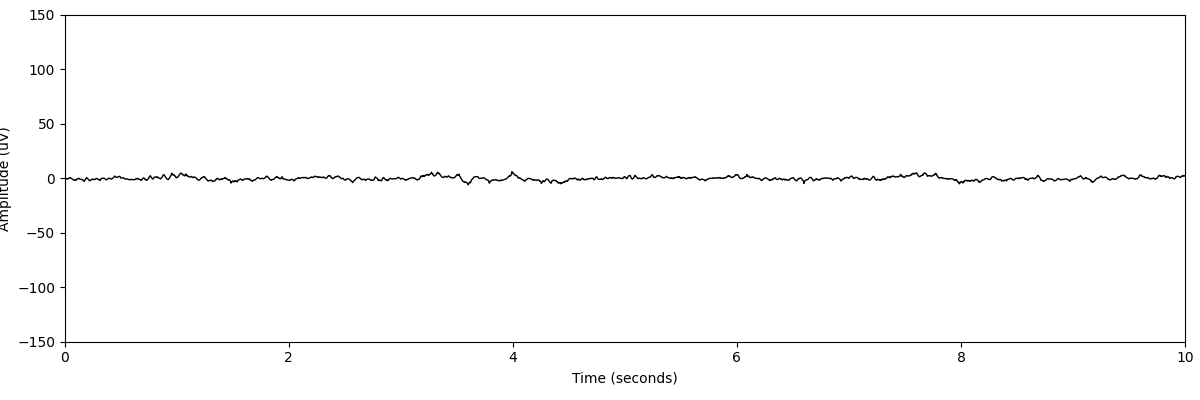

In [12]:
%matplotlib widget
sw.plot_detection()

### K-Complex Detection

In [13]:
# If not passing an MNE raw object, you will need to convert 
# values from V to uV and specify sf (sampling_freq) and ch_names
kc = sw_detect(rz_data,
               sf = sampling_freq,
               ch_names = raw.ch_names,
               hypno = hypnogram, # optionally load a hypnogram file
               include = (2, 3), # only include KC's detected in N2 and N3 sleep (if hypnogram is specified)
               freq_sw = (0.3, 4.0), # bandpass to look at events (Hz) 
               dur_neg = (0.3, 1), # min/max duration of negative deflection (seconds)
               dur_pos = (0.1, 0.5), # min/max duration of positive reflection (seconds)
               amp_neg = (5.0, None), # min/max peak amplitude of negative deflection (uV); can be (None, None)
               amp_pos = (None, None), # min/max peak amplitude of positive reflection (uV); can be (None, None)
               amp_ptp = (5.0, np.inf), # min/max peak-to-peak amplitude (uV); upper limit can be set as np.inf
               coupling = False, # irrelevant to us (see documentation)
               remove_outliers = True, # automatically remove outliers using sklearn's Isolation Forest
               verbose = False)

k_complexes = kc.summary()
k_complexes['ID'] = k_complexes.index + 1

# Print summary/plot
kc.summary(grp_stage = True)
#kc.plot_average(center = 'NegPeak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
10-Sep-23 11:15:55 | WARNING | No SW were found in channel RPHC9.
10-Sep-23 11:15:55 | WARNING | No SW were found in channel RPC3.
10-Sep-23 11:15:56 | WARNING | No SW were found in channel RPC9.
10-Sep-23 11:15:56 | WARNING | No SW were found in channel RPC10.
10-Sep-23 11:15:56 | WARNING | No SW were found in channel RSMA7.
10-Sep-23 11:15:59 | WARNING | No SW were found in channel LHC8.
10-Sep-23 11:16:01 | WARNING | No SW were found in channel ROF9.
10-Sep-23 11:16:01 | WARNING | No SW were found in channel RAC7.


,Count,Density,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Stage,,,,,,,,
2,5327,18.067835,0.788846,-7.132062,3.910218,11.042280,66.619798,1.327987
3,176,11.733333,0.859572,-5.957728,2.851618,8.809346,40.680578,1.213710


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

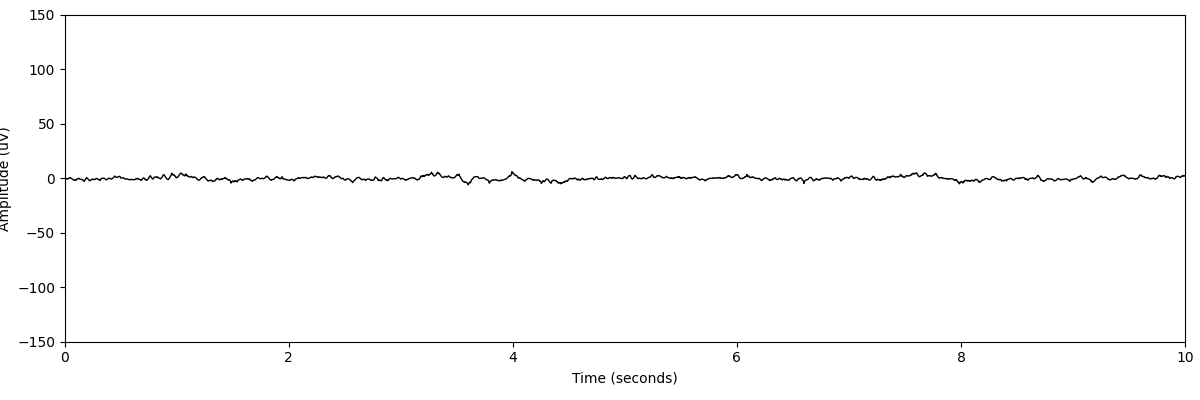

In [14]:
%matplotlib widget
kc.plot_detection()

### Spindle Detection

In [15]:
sp = spindles_detect(data,
                     sf = sampling_freq,
                     ch_names = raw.ch_names,
                     hypno = hypnogram, # optionally load a hypnogram file
                     include = (2, 3), # only include spindles detected in N2 and N3 sleep (if hyponogram is specified)
                     freq_sp = (12, 15), # bandpass to look at spindles (Hz)
                     freq_broad = (1, 30), # broadband frequency range (Hz)
                     duration = (0.5, 2), # min/max duration of spindles (seconds)
                     min_distance = 500, # merge threshold of adjacent spindles (milliseconds)
                     #thresh = {'rel_pow': ?it's a ratio?, # relative power (freq_sp / freq_broad)
                     #          'corr': ?, # moving correlation between original and sigma-filtered signals
                     #          'rms': ?}, # standard deviations above mean of moving RMS of sigma-filtered signal
                     multi_only = False, # if True, only keeps spindles present in at least two channels
                     remove_outliers = True, # detect and remove outliers using sklearn's Isolation Forest
                     )

spindles = sp.summary()
spindles['ID'] = spindles.index + 1

# Print summary/plot
sp.summary(grp_stage = True)
#sp.plot_average(center = 'Peak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s
10-Sep-23 11:18:04 | WARNING | No spindle were found in channel LAM1.
10-Sep-23 11:19:21 | WARNING | No spindle were found in channel RAM1.
10-Sep-23 11:19:24 | WARNING | No spindle were found in channel RAM2.


,Count,Density,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Stage,,,,,,,,,,
2,45350,153.815715,1.054266,162.710153,33.708336,2.944412,0.405563,13.415921,12.978104,0.51809
3,991,66.066667,0.925801,180.559548,39.240827,3.106349,0.361107,13.203779,11.688194,0.50753


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

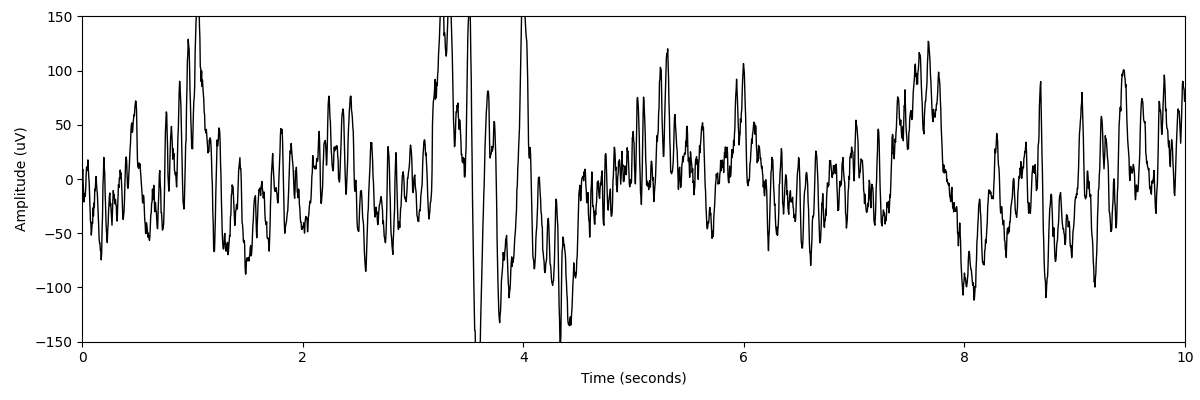

In [16]:
%matplotlib widget
sp.plot_detection()

### Summarize Events & Export

Remove channel events if the channel detected less than the event threshold.

In [17]:
# Extract event counts by channel
sw_sum = sw.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
sw_sum = sw_sum[['Channel', 'Count']]
sw_sum.columns = ['channel', 'sw']

kc_sum = kc.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
kc_sum = kc_sum[['Channel', 'Count']]
kc_sum.columns = ['channel', 'kc']

sp_sum = sp.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
sp_sum = sp_sum[['Channel', 'Count']]
sp_sum.columns = ['channel', 'sp']

# Merge event counts and export to CSV
event_sum = pd.merge(sw_sum, kc_sum, on = ['channel'])
event_sum = pd.merge(event_sum, sp_sum, on = ['channel'])
event_sum.to_csv(event_path, index = False)

# Save sleep events to CSV
slow_waves.to_csv(sw_path, index = False)
k_complexes.to_csv(kc_path, index = False)
spindles.to_csv(sp_path, index = False)